In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_imgs_path = data_dir /  'sun_IF'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [5]:
df_imgs

,Cell,Condition,FOV,Path
0,HCC827,O,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
1,HCC827,O,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
2,HCC827,ctrl,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
3,HCC827,ctrl,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
4,PC9,O,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
5,PC9,O,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
6,PC9,ctrl,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
7,PC9,ctrl,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...


# QC segmentation

In [6]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_cyto(mask_cyto,  small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    return mask_cyto

In [7]:
# Read masks paths 
mask_dir = data_dir / 'sun_IF' / 'imgs' / 'masks'
mask_filt_dir = data_dir / 'sun_IF' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [8]:
masks_path

defaultdict(dict,
            {'HCC827_ctrl_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/HCC827_ctrl_fixed.png')},
             'HCC827_ctrl_live': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/HCC827_ctrl_live.png')},
             'HCC827_O_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/HCC827_O_fixed.png')},
             'HCC827_O_live': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/HCC827_O_live.png')},
             'PC9_ctrl_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/PC9_ctrl_fixed.png')},
             'PC9_ctrl_live': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/PC9_ctrl_live.png')},
             'PC9_O_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_IF/imgs/masks/PC9_O_fixed.png')},
             'PC9_O_live': {'c

In [ ]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join(row[1:4])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    cell = qc_cyto(mask_cyto)
    
    file_path =  mask_filt_dir / f'{name}.tif'
    tiff.imwrite(file_path, cell)

# PLA quantification

In [10]:
import PLA
from skimage import filters

PPI_save_path =  data_dir /   'sun_IF'   / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [11]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        # imgs = f['cycle1'][:]
        markers = f['imgs'].attrs['Marker']
    print(markers)
    break

['Hoechst' 'DR5' 'TRAIL' 'Hoechst' 'Phalloidin']


In [12]:
RNAs = ['DR5', 'TRAIL']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='imgs', m='Marker')
    
    with h5py.File(path, 'r') as f:
        imgs = f['imgs'][:]
        markers = f['imgs'].attrs['Marker']
    
    imgs_raw = []
    for i, img in enumerate(imgs):
        if markers[i] in RNAs:
            imgs_raw.append(img)

    masks = []
    for i, img in enumerate(imgs_raw):
        thresh = filters.threshold_otsu(img)
        mask = (img > thresh+0.025)
        masks.append(mask)

        name = '_'.join(row[1:4]) + f'_{RNAs[i]}.png'
        skimage.io.imsave(PPI_save_path / name, mask)

        name = '_'.join(row[1:4]) + f'_{RNAs[i]}_raw.tiff'
        skimage.io.imsave(PPI_save_path / name, img)

    # Open a file and use dump()
    name = '_'.join(row[1:4]) +'.pkl'
    with open(PPI_save_path / name, 'wb') as file:
        pickle.dump(masks, file, pickle.HIGHEST_PROTOCOL)

C:\Users\thu71\AppData\Local\Temp\ipykernel_55380\212736615.py:24: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\sun_IF\PPI\HCC827_O_fixed_DR5.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave(PPI_save_path / name, mask)
C:\Users\thu71\AppData\Local\Temp\ipykernel_55380\212736615.py:27: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\sun_IF\PPI\HCC827_O_fixed_DR5_raw.tiff is a low contrast image
  skimage.io.imsave(PPI_save_path / name, img)
C:\Users\thu71\AppData\Local\Temp\ipykernel_55380\212736615.py:24: UserWarning: \\bme-retromaster.ad.gatech.edu\labs5\coskun-lab\Thomas\23_PLA_revision\data\sun_IF\PPI\HCC827_O_fixed_TRAIL.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave(PPI_save_path / name, mask)
C

In [35]:
import napari

viewer = napari.view_image(np.stack(masks))
# viewer.add_image(np.stack(img))
viewer.add_image(np.stack(imgs_raw))

<Image layer 'Image [1]' at 0x180d57dee10>

# Extract per cell Coloc count

In [13]:
import pickle 
from sklearn.neighbors import NearestNeighbors
import scipy 
from skimage import measure 

def read_mask(path):
    with open(path, 'rb') as file:
        masks = pickle.load(file)

    return masks

def positives(regionmask, intensity):
    return np.sum(intensity[regionmask])

def quartiles(regionmask, intensity):
    return np.percentile(intensity[regionmask], q=(25, 50, 75))

In [14]:
mask_filt_dir = data_dir /  'sun_IF'   / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir /  'sun_IF'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    masks_path[name] = mask_filt_dir / path
    

In [15]:
RNAs = ['DR5', 'TRAIL']

In [16]:
manual_mask_dir = Path(r'Y:\coskun-lab\Thomas\23_PLA_revision\data\sun_IF\PPI\new threshold')

In [17]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:4])
    
    # Read masks
    mask_cyto_path = masks_path[name]
    
    mask_cyto = skimage.io.imread(mask_cyto_path)

    # Read IF marker mask images
    masks = read_mask(PPI_save_path / f'{name}.pkl')
    mask_DR5 = masks[0]
    mask_TRAIL = masks[1]
    for r in RNAs:
        if os.path.exists(manual_mask_dir / f'{name}_{r}_raw.png'):
            print('Reading new masks')
            if r == 'DR5':
                mask_DR5 = skimage.io.imread(manual_mask_dir / f'{name}_{r}_raw.png')
            else:
                mask_TRAIL = skimage.io.imread(manual_mask_dir / f'{name}_{r}_raw.png')
    mask_and = (mask_DR5 & mask_TRAIL)
    mask_or = (mask_DR5 | mask_TRAIL)

    # Get dataframe
    df_and = pd.DataFrame(measure.regionprops_table(mask_cyto, intensity_image=mask_and.astype(np.uint8), 
                                            properties=('label', ), 
                                            extra_properties=(positives,)))
    df_or = pd.DataFrame(measure.regionprops_table(mask_cyto, intensity_image=mask_or.astype(np.uint8), 
                                            properties=('label', ), 
                                            extra_properties=(positives,)))
    df = df_and.merge(df_or, on='label')
    df.columns=['Id', 'Pixel coloc', 'Total']
    df['Cell'] = row.Cell
    df['Condition'] = row.Condition
    df['FOV'] = row.FOV

    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df.to_csv(path, index=False)

Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks
Reading new masks


# Quantification

In [18]:
# Read PPI
PPI_save_path =  data_dir / 'sun_IF' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [19]:
df['Density'] = df['Pixel coloc'].div(df['Total'])
df['PPI'] = 'DR5/TRAIL'

In [20]:
# Get nuclei and cell count
df_cell = df[['Cell', 'Condition', 'FOV', 'PPI', 'Id', 'Density']]
df_cell = (df_cell.pivot_table(values='Density', columns='PPI', index=['Cell','Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Cell', 'Condition', 'FOV','Id'], value_name='Density', var_name='PPI')
)


In [21]:
# Describe statistics
df_cell.groupby(['Cell', 'Condition', 'FOV', 'PPI'])['Density'].describe()

count      mean       std  min       25%  \
Cell   Condition FOV   PPI                                                   
HCC827 O         fixed DR5/TRAIL  359.0  0.000459  0.000921  0.0  0.000000   
                 live  DR5/TRAIL  438.0  0.036723  0.114805  0.0  0.000000   
       ctrl      fixed DR5/TRAIL  354.0  0.036923  0.064624  0.0  0.000000   
                 live  DR5/TRAIL  486.0  0.069713  0.137751  0.0  0.000000   
PC9    O         fixed DR5/TRAIL  417.0  0.000176  0.000450  0.0  0.000000   
                 live  DR5/TRAIL  400.0  0.040571  0.064660  0.0  0.000000   
       ctrl      fixed DR5/TRAIL  445.0  0.024729  0.074803  0.0  0.000000   
                 live  DR5/TRAIL  362.0  0.153698  0.120239  0.0  0.063437   

                                       50%       75%       max  
Cell   Condition FOV   PPI                                      
HCC827 O         fixed DR5/TRAIL  0.000000  0.000446  0.003922  
                 live  DR5/TRAIL  0.000000  0.017145  1.000000  
       ctrl      fixed DR5/TRAIL  0.005818  0.047041  0.381906  
                 live  DR5/TRAIL  0.011766  0.078075  1.000000  
PC9    O         fixed DR5/TRAIL  0.000000  0.000136  0.003906  
                 live  DR5/TRAIL  0.019793  0.053713  0.560000  
       ctrl      fixed DR5/TRAIL  0.000000  0.018182  0.789443  
                 live  DR5/TRAIL  0.123200  0.221097  0.604096

# Comparison between condition

In [22]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(7,7), y_title='IF coloc density'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

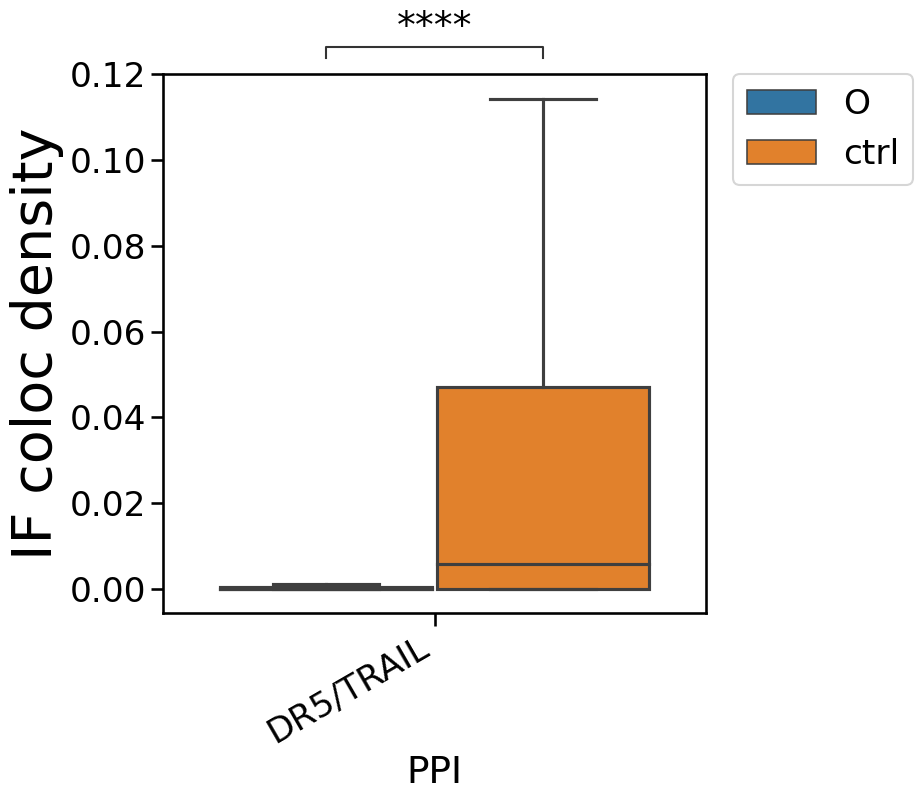

In [24]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'HCC827') & (df_cell.FOV == 'fixed')],
    "x": "PPI",
    "y": "Density",
    "hue": "Condition"
}

plot(plotting)

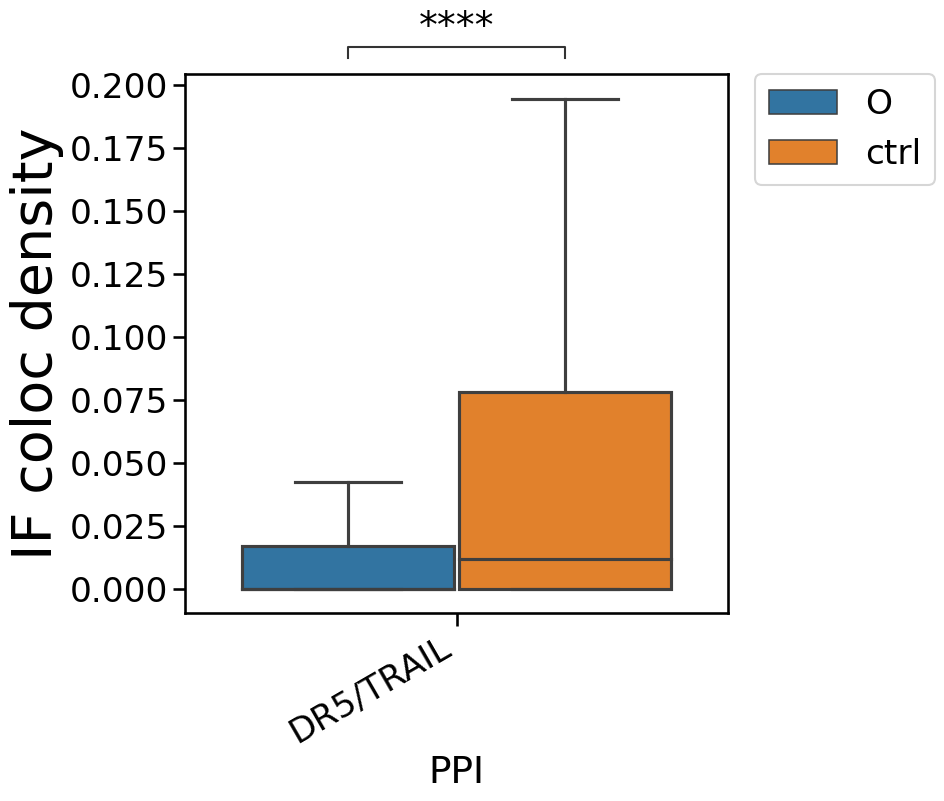

In [23]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'HCC827') & (df_cell.FOV == 'live')],
    "x": "PPI",
    "y": "Density",
    "hue": "Condition"
}

plot(plotting)

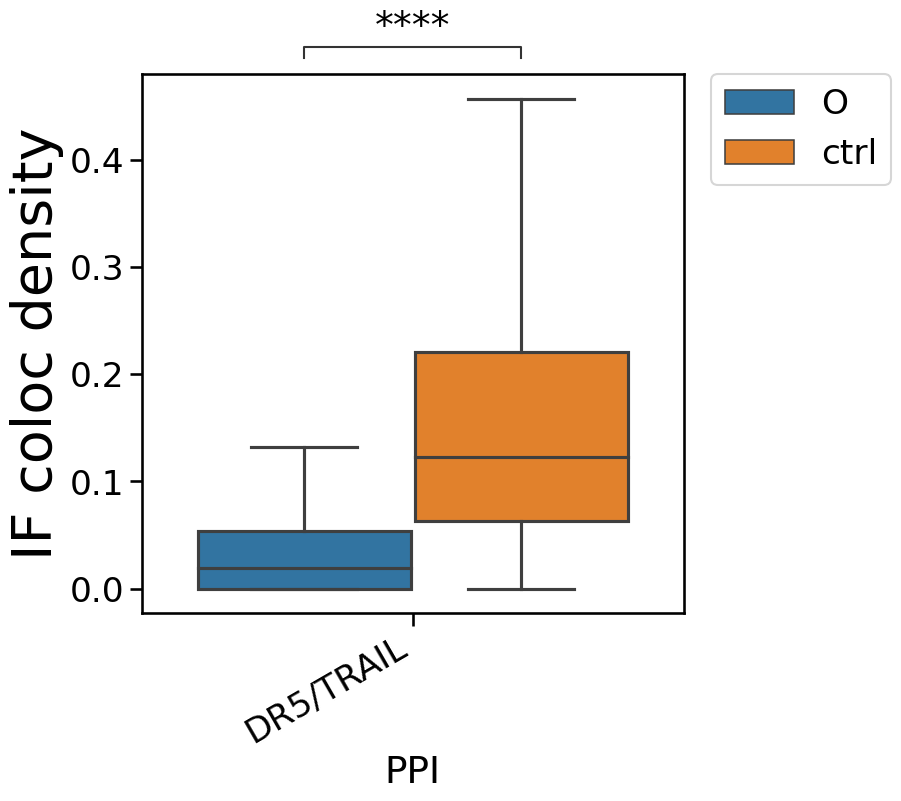

In [25]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'PC9') & (df_cell.FOV == 'live')],
    "x": "PPI",
    "y": "Density",
    "hue": "Condition"
}

plot(plotting)

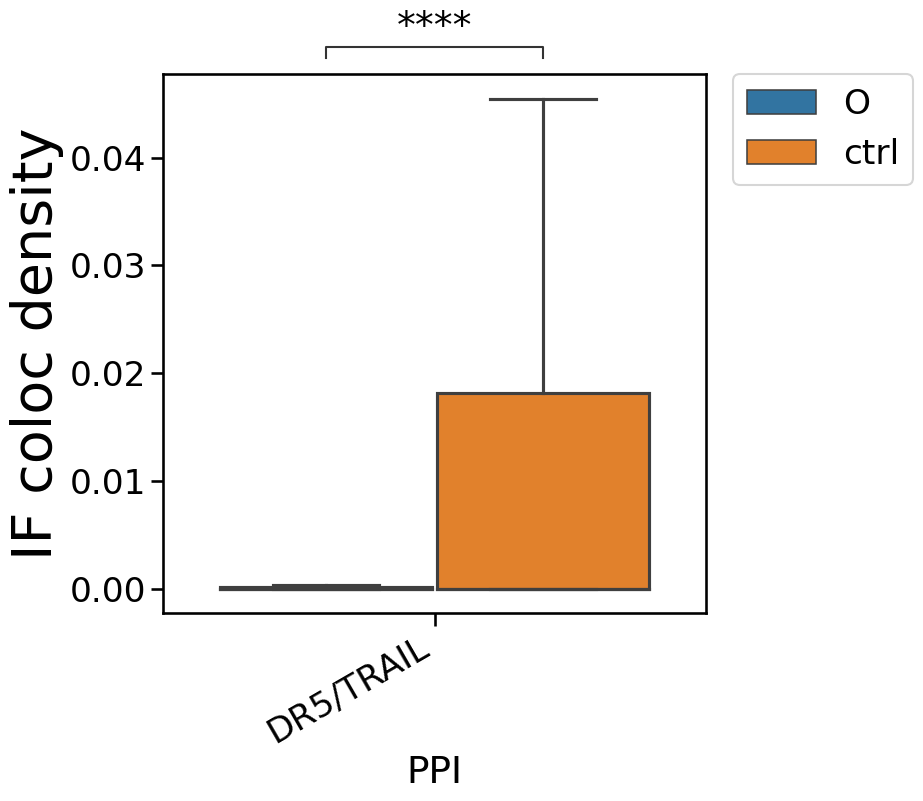

In [26]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'PC9') & (df_cell.FOV == 'fixed')],
    "x": "PPI",
    "y": "Density",
    "hue": "Condition"
}

plot(plotting)